# Example and timings

This notebook gives a short introduction in how to use pydpc for a simple clustering problem.

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pydpc import Cluster
from pydpc._reference import Cluster as RefCluster

We start with preparing the data points for clustering. The data is two-dimensional and craeted by drawing random numbers from four superpositioned gaussian distributions which are centered at the corners of a square (indicated by the red dashed lines).

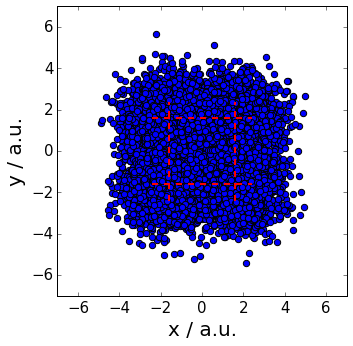

In [2]:
# generate the data points
npoints = 10000
mux = 1.6
muy = 1.6
points = np.zeros(shape=(npoints, 2), dtype=np.float64)
points[:, 0] = np.random.randn(npoints) + mux * (-1)**np.random.randint(0, high=2, size=npoints)
points[:, 1] = np.random.randn(npoints) + muy * (-1)**np.random.randint(0, high=2, size=npoints)
# draw the data points
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(points[:, 0], points[:, 1], s=40)
ax.plot([-mux, -mux], [-1.5 * muy, 1.5 * muy], '--', linewidth=2, color="red")
ax.plot([mux, mux], [-1.5 * muy, 1.5 * muy], '--', linewidth=2, color="red")
ax.plot([-1.5 * mux,  1.5 * mux], [-muy, -muy], '--', linewidth=2, color="red")
ax.plot([-1.5 * mux,  1.5 * mux], [muy, muy], '--', linewidth=2, color="red")
ax.set_xlabel(r"x / a.u.", fontsize=20)
ax.set_ylabel(r"y / a.u.", fontsize=20)
ax.tick_params(labelsize=15)
ax.set_xlim([-7, 7])
ax.set_ylim([-7, 7])
ax.set_aspect('equal')
fig.tight_layout()

In [3]:
points.shape

(10000L, 2L)

In [4]:
points = points.astype('float32')

Now comes the interesting part.

We pass the numpy ndarray with the data points to the ``Cluster`` class which prepares the data set for clustering. In this stage, it computes the Euclidean distances between all data points and from that the two properties to identify clusters within the data: each data points' ``density`` and minimal distance ``delta`` to a point of higher density.

Once these properties are computed, a decision graph is drawn, where each outlier in the upper right corner represents a different cluster. In our example, we should find four outliers. So far, however, no clustering has yet been done.

In [5]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import euclidean_distances
%time pair_dis = euclidean_distances(points)

Wall time: 1.34 s


Wall time: 2.88 s


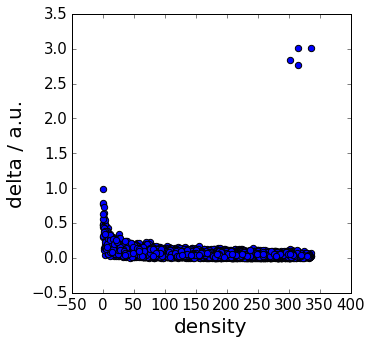

In [6]:
clu = Cluster(points, fraction=0.02, autoplot=True)

In [7]:
X = np.random.random((500, 3))
pairwise_distances(X)

array([[ 0.        ,  0.86731454,  1.56161838, ...,  1.29620686,
         0.80829531,  0.85730796],
       [ 0.86731454,  0.        ,  0.97737077, ...,  1.03155849,
         0.522375  ,  0.66062953],
       [ 1.56161838,  0.97737077,  0.        , ...,  0.52264344,
         0.81077553,  0.8313839 ],
       ..., 
       [ 1.29620686,  1.03155849,  0.52264344, ...,  0.        ,
         0.66779297,  0.59963091],
       [ 0.80829531,  0.522375  ,  0.81077553, ...,  0.66779297,
         0.        ,  0.5326746 ],
       [ 0.85730796,  0.66062953,  0.8313839 , ...,  0.59963091,
         0.5326746 ,  0.        ]])

In [8]:
clu.density.shape
# np.argsort(clu.density)

(10000L,)

In [9]:
from pydpc import core
dens = core.get_density(clu.distances, 0.531)
dens

array([ 262.2510164 ,  243.94240473,  192.57923501, ...,  108.08981082,
        224.80268458,  127.35661587])

In [10]:
from scipy.spatial.distance import squareform
import numexpr as ne

def get_density(dis, kernel_size):
#     dens_ = np.exp(-(clu.distances/0.531)**2) # this is much slower
    dens_0 = ne.evaluate("exp(-(dis/0.531)**2)")
    dens_1 = ne.evaluate("sum(dens_0, axis=1)")
    return dens_1-1

In [11]:
get_density(clu.distances, 0.531)

array([ 262.2510164 ,  243.94240473,  192.57923501, ...,  108.08981812,
        224.80268308,  127.35663056])

In [12]:
from scipy.spatial.distance import squareform
# %time dis = squareform(clu.distances,checks=False)
dis = clu.distances.ravel()
dis.shape

(100000000L,)

In [13]:
np.percentile(dis[::100], 2)

0.53118529796600333

Now that we have the decision graph, we can select the outliers via the ``assign`` method by setting lower bounds for ``delta`` and ``density``. The assign method does the actual clustering; it also shows the decision graph again with the given selection.

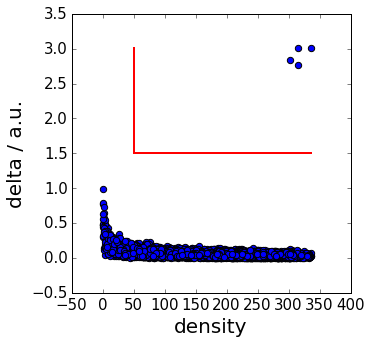

In [14]:
clu.assign(50, 1.5)

Let us have a look at the result.

We again plot the data and red dashed lines indicating the centeres of the gaussian distributions. Indicated in the left panel by red dots are the four outliers from the decision graph; these are our four cluster centers. The center panel shows the points' densities and the right panel shows the membership to the four clusters by different coloring.

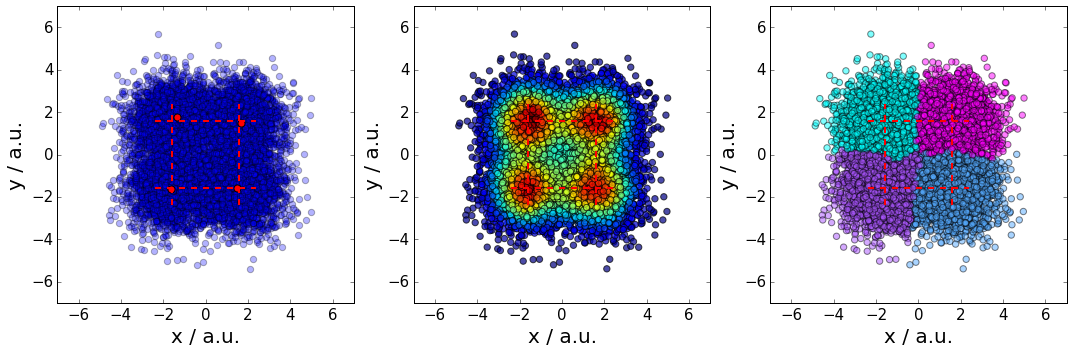

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(points[:, 0], points[:, 1], s=40, alpha=0.3)
ax[0].scatter(points[clu.clusters, 0], points[clu.clusters, 1], s=50, c="red")
ax[1].scatter(points[:, 0], points[:, 1], s=40, c=clu.density, alpha=0.7)
ax[2].scatter(points[:, 0], points[:, 1], s=40, c=clu.membership, cmap=mpl.cm.cool, alpha=0.5)
for _ax in ax:
    _ax.plot([-mux, -mux], [-1.5 * muy, 1.5 * muy], '--', linewidth=2, color="red")
    _ax.plot([mux, mux], [-1.5 * muy, 1.5 * muy], '--', linewidth=2, color="red")
    _ax.plot([-1.5 * mux,  1.5 * mux], [-muy, -muy], '--', linewidth=2, color="red")
    _ax.plot([-1.5 * mux,  1.5 * mux], [muy, muy], '--', linewidth=2, color="red")
    _ax.set_xlabel(r"x / a.u.", fontsize=20)
    _ax.set_ylabel(r"y / a.u.", fontsize=20)
    _ax.tick_params(labelsize=15)
    _ax.set_xlim([-7, 7])
    _ax.set_ylim([-7, 7])
    _ax.set_aspect('equal')
fig.tight_layout()

The density peak clusterng can further resolve if the membership of a data point to a certain cluster is strong or rather weak and separates the data points further into core and halo regions.

The left panel depicts the border members in grey.
The separation in the center panel uses the core/halo criterion of the original authors, the right panel shows a less strict criterion which assumes a halo only between different clusters; here, the halo members are depicted in grey.

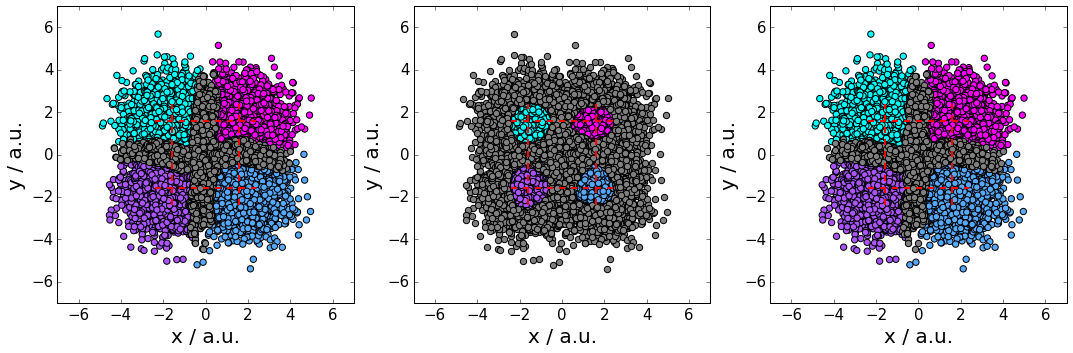

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(
    points[:, 0], points[:, 1],
    s=40, c=clu.membership, cmap=mpl.cm.cool)
ax[0].scatter(points[clu.border_member, 0], points[clu.border_member, 1], s=40, c="grey")
ax[1].scatter(
    points[clu.core_idx, 0], points[clu.core_idx, 1],
    s=40, c=clu.membership[clu.core_idx], cmap=mpl.cm.cool)
ax[1].scatter(points[clu.halo_idx, 0], points[clu.halo_idx, 1], s=40, c="grey")
clu.autoplot=False
clu.assign(20, 1.5, border_only=True)
ax[2].scatter(
    points[clu.core_idx, 0], points[clu.core_idx, 1],
    s=40, c=clu.membership[clu.core_idx], cmap=mpl.cm.cool)
ax[2].scatter(points[clu.halo_idx, 0], points[clu.halo_idx, 1], s=40, c="grey")
ax[2].tick_params(labelsize=15)
for _ax in ax:
    _ax.plot([-mux, -mux], [-1.5 * muy, 1.5 * muy], '--', linewidth=2, color="red")
    _ax.plot([mux, mux], [-1.5 * muy, 1.5 * muy], '--', linewidth=2, color="red")
    _ax.plot([-1.5 * mux,  1.5 * mux], [-muy, -muy], '--', linewidth=2, color="red")
    _ax.plot([-1.5 * mux,  1.5 * mux], [muy, muy], '--', linewidth=2, color="red")
    _ax.set_xlabel(r"x / a.u.", fontsize=20)
    _ax.set_ylabel(r"y / a.u.", fontsize=20)
    _ax.tick_params(labelsize=15)
    _ax.set_xlim([-7, 7])
    _ax.set_ylim([-7, 7])
    _ax.set_aspect('equal')
fig.tight_layout()

This concludes the example.

In the remaining part, we address the performance of the pydpc implementation (numpy + cython-wrapped C code) with respect to an older development version (numpy). In particular, we look at the numerically most demanding part of computing the Euclidean distances between the data points and estimating density and delta.

In [17]:
npoints = 1000
points = np.zeros(shape=(npoints, 2), dtype=np.float64)
points[:, 0] = np.random.randn(npoints) + 1.8 * (-1)**np.random.randint(0, high=2, size=npoints)
points[:, 1] = np.random.randn(npoints) + 1.8 * (-1)**np.random.randint(0, high=2, size=npoints)

%timeit Cluster(points, fraction=0.02, autoplot=False)
%timeit RefCluster(fraction=0.02, autoplot=False).load(points)

10 loops, best of 3: 25.7 ms per loop
1 loop, best of 3: 5.78 s per loop


The next two cells measure the full clustering.

In [8]:
%%timeit
Cluster(points, fraction=0.02, autoplot=False).assign(20, 1.5)

10 loops, best of 3: 63.1 ms per loop


In [9]:
%%timeit
tmp = RefCluster(fraction=0.02, autoplot=False)
tmp.load(points)
tmp.assign(20, 1.5)

1 loop, best of 3: 5.73 s per loop


In [16]:
whos

Variable              Type        Data/Info
-------------------------------------------
Cluster               type        <class 'pydpc.dpc.Cluster'>
RefCluster            type        <class 'pydpc._reference.Cluster'>
X                     ndarray     500Lx3L: 1500 elems, type `float64`, 12000 bytes
ax                    ndarray     3L: 3 elems, type `object`, 24 bytes
clu                   Cluster     <pydpc.dpc.Cluster object at 0x0000000017F742E8>
core                  module      <module 'pydpc.core' from<...>c-master\pydpc\core.pyd'>
dens                  ndarray     10000L: 10000 elems, type `float64`, 80000 bytes
dis                   ndarray     100000000L: 100000000 elems, type `float64`, 800000000 bytes (762 Mb)
euclidean_distances   function    <function euclidean_dista<...>es at 0x0000000017B8B9E8>
fig                   Figure      Figure(1200x400)
get_density           function    <function get_density at 0x0000000017E5DA58>
mpl                   module      <module 'matp